In [4]:
import torch
from torch import nn
import numpy as np
import time
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 2.5]

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NN(nn.Module):
    def __init__(self, d):
        super(NN, self).__init__()
        self.stack = nn.Sequential(
            nn.Linear(1, d),
            nn.SiLU(), # nn.Tanh()
            nn.Linear(d, d),
            nn.SiLU(), # nn.Tanh()
            nn.Linear(d, d),
            nn.SiLU(), # nn.Tanh()
            nn.Linear(d, d),
            nn.SiLU(), # nn.Tanh()
            nn.Linear(d, 1)
        )

    def forward(self, x):
        return self.stack(x)

def train(model, N, a, b, epochs, loss, optimizer, show_stats=False):
    X = torch.linspace(a, b, N, requires_grad=True).reshape(N, 1)

    for e in range(0, epochs):
        optimizer.zero_grad()
        output = model(X)

        total_loss = 0
        for coef, fn in loss:
            total_loss += coef*fn(X, output)

        total_loss.backward()
        optimizer.step()

        if show_stats: 
            if e % (epochs/8) == 0:
                    print(f"Epoch: {e}\t Total Loss: {total_loss}")

def dx(f, wrt, n):
    f = torch.sum(f)
    for i in range(n):
        grads = torch.autograd.grad(f, wrt, create_graph=True)[0]
        f = grads.sum()
    return grads

Using cuda device


In [23]:
# Loss functions


# y' = e^x; y(0) = 1
loss_a = [[None, lambda x, y: torch.linalg.norm(dx(y, x, 1) - torch.exp(x), ord=2)],
          [None, lambda x, y: torch.linalg.norm(y[0] - 1, ord=2)]]
fn_a = lambda x: torch.exp(x)

# y' = x; y(0) = 1 ... k = 1; alph = 30
loss_b = [[None, lambda x, y: torch.linalg.norm(dx(y, x, 1) - x, ord=2)],
          [None, lambda x, y: torch.linalg.norm(y[0] - 1, ord=2)]]
fn_b = lambda x: (1/2)*(x**2 + 2)

# 5y' - 4y^2 = 0; y(0) = -8
loss_c = [[None, lambda x, y: torch.linalg.norm(5*dx(y, x, 1) - 4*y**2, ord=2)],
          [None, lambda x, y: torch.linalg.norm(y[0] + 8, ord=2)]]
fn_c = lambda x: -40/(32*x + 5)

# 10y''+ 5y = 0; y(0) = 0; y'(0) = 1 ... k = 1; alph = 1; beta = 5000
loss_d = [[None, lambda x, y: torch.linalg.norm(10*dx(y, x, 2) + 5*y, ord=2)],
          [None, lambda x, y: torch.linalg.norm(y[0], ord=2)],
          [None, lambda x, y: torch.linalg.norm(dx(y[0], x, 1) - 1, ord=2)]]
fn_d = lambda x: np.sqrt(2)*torch.sin(x/np.sqrt(2))

# 10y''+ 2y' + 2y = 0; y(0) = -10; y'(0) = 0
loss_e = [[None, lambda x, y: torch.linalg.norm(10*dx(y, x, 2) + 2*dx(y, x, 1) + 2*y, ord=2)],
          [None, lambda x, y: torch.linalg.norm(y[0] + 10, ord=2)],
          [None, lambda x, y: torch.linalg.norm(dx(y[0], x, 1), ord=2)]]
fn_e = lambda x: -(10/19) *  torch.exp(-x/10) * (np.sqrt(19)*torch.sin((np.sqrt(19)*x)/10) + 19*torch.cos((np.sqrt(19)*x)/10))

optimal beta: 5.0


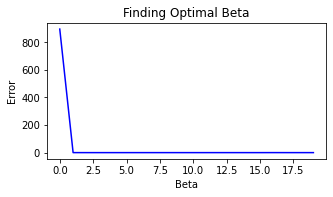

In [24]:
# Finding optimal beta value for first order ODEs


loss = loss_a.copy()
loss[0][0] = 1 # Set alpha to 1

a = 0
b = 5
N = 50
epochs = 10000

# Test x points
x = torch.linspace(a, b, 1000).reshape(1000, 1)

betas = np.arange(0, 20, 1)
stats = []

for beta in betas:

    # Adjust the loss function
    loss[1][0] = beta
    
    # Train the model 
    model = NN(20)
    optimizer = torch.optim.Adam(model.parameters(), lr=.001)
    train(model, N, a, b, epochs, loss, optimizer, show_stats=False)

    # Calculate the error
    y = fn_a(x.reshape(1000, 1))
    y_hat = model(x.reshape(1000, 1)).detach()
    error = float(torch.mean((y - y_hat)**2))
    stats.append([error, beta])

stats = np.asarray(stats)
min_index = np.argmin(stats[:, 0], axis=0)
opt_beta = stats[:, 1][min_index]
loss[0][0] = 1
loss[1][0] = opt_beta

print(f"optimal beta: {opt_beta}")
plt.plot(stats[:, 1], stats[:, 0], 'b')
plt.title("Finding Optimal Beta")
plt.ylabel("Error")
plt.xlabel("Beta")
plt.show()

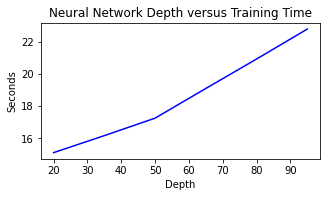

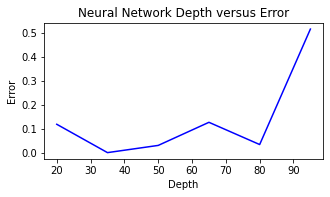

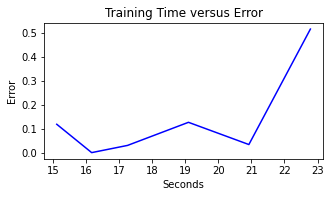

In [25]:
# Finding optimal depth value for first order ODEs


a = 0
b = 5
N = 50
epochs = 10000

depths = np.arange(20, 100, 15)
stats = []
for depth in depths:

    # Create the  model and train
    model = NN(depth)
    optimizer = torch.optim.Adam(model.parameters(), lr=.001)

    start_time = time.time()
    train(model, N, a, b, epochs, loss, optimizer, show_stats=False)
    train_time = time.time() - start_time

    # Calculate the stats
    y = fn_a(x.reshape(1000, 1))
    y_hat = model(x.reshape(1000, 1)).detach()
    error = float(torch.mean((y - y_hat)**2))
    stats.append([error, train_time, depth])

stats = np.asarray(stats)

plt.figure(1)
plt.plot(stats[:, 2], stats[:, 1], color='b')
plt.title("Neural Network Depth versus Training Time")
plt.ylabel("Seconds")
plt.xlabel("Depth")

plt.figure(2)
plt.plot(stats[:, 2], stats[:, 0], color='b')
plt.title("Neural Network Depth versus Error")
plt.ylabel("Error")
plt.xlabel("Depth")

plt.figure(3)
plt.plot(stats[:, 1], stats[:, 0], color='b')
plt.title("Training Time versus Error")
plt.ylabel("Error")
plt.xlabel("Seconds")

plt.show()

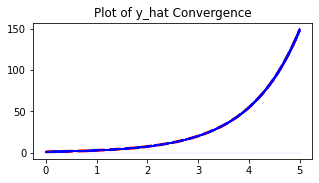

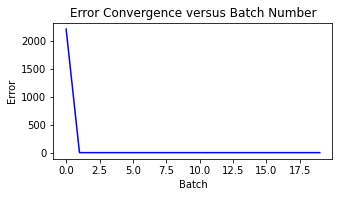

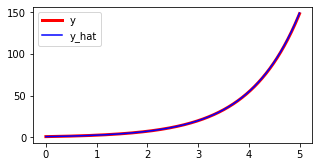

In [26]:
model = NN(35)
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

batch_count = 20

y = fn_a(x)
plt.figure(1)
plt.plot(x, y, color='r', linestyle="dashed", linewidth=3)
error = []

# Train in batches
for batch in range(batch_count):

    # Calculate Error
    y_hat = model(x).detach()
    plt.plot(x, y_hat, color='b', alpha=(batch + 1)/batch_count)
    error.append(float(torch.mean((y - y_hat)**2)))

    # Train the model
    train(model, 200, 0, 5, 750, loss, optimizer, show_stats=False)

plt.title("Plot of y_hat Convergence")
plt.show()

plt.figure(2)
plt.plot(error, color='b')
plt.title("Error Convergence versus Batch Number")
plt.xlabel("Batch")
plt.ylabel("Error")

plt.figure(3)
y = fn_a(x)
y_hat = model(x).detach()
plt.plot(x, y, color='r', lw=3, label="y")
plt.plot(x, y_hat, color='b', label="y_hat")
plt.legend()
plt.show()

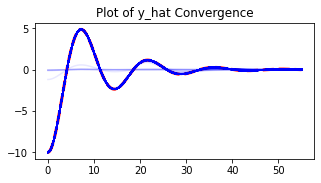

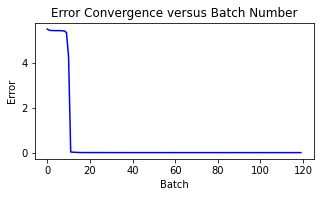

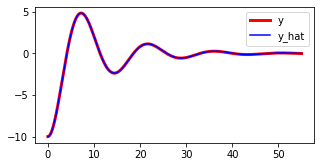

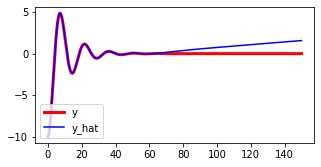

In [27]:
# Fitting second order differential equations. 

loss2 = loss_e.copy()
loss2[0][0] = 1 # alpha
loss2[1][0] = 1 # beta 
loss2[2][0] = 50 # gamma

model = NN(20)
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

a = 0
b = 55
N = 300

x = torch.linspace(a, b, 1000).reshape(1000, 1)
y = fn_e(x)
plt.figure(1)
plt.plot(x, y, color='r', linestyle="dashed", linewidth=3)

batch_count = 120
error = []

# Train in batches
for batch in range(batch_count):

    # Calculate Error
    y_hat = model(x).detach()
    plt.plot(x, y_hat, color='b', alpha=(batch + 1)/batch_count)
    error.append(float(torch.mean((y - y_hat)**2)))

    # Train the model
    train(model, N, a, b, 750, loss2, optimizer, show_stats=False)

plt.title("Plot of y_hat Convergence")

plt.figure(2)
plt.plot(error, color='b')
plt.title("Error Convergence versus Batch Number")
plt.xlabel("Batch")
plt.ylabel("Error")

plt.figure(3)
plt.plot(x, y, color='r', lw=3, label="y")
plt.plot(x, y_hat, color='b', label="y_hat")
plt.legend()
plt.show()

plt.figure(4)
x = torch.linspace(a, 150, 1500).reshape(1500, 1)
y = fn_e(x)
y_hat = model(x).detach()
plt.plot(x, y, color='r', lw=3, label="y")
plt.plot(x, y_hat, color='b', label="y_hat")
plt.legend(loc="lower left")
plt.show()

N: 20


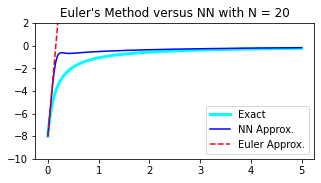

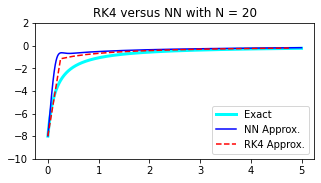

In [28]:
# Comparison to Traditional Methods


a = 0
b = 5
k = .25
x_points = np.arange(a, b, k)
N = x_points.shape[0]
dy = lambda x, y: (4*(y*y))/5
y0 = -8

# Euler's Method
euler_y = [y0]
for i in range(N-1):
    x = x_points[i]
    euler_y.append(k*dy(x, euler_y[-1]) + euler_y[-1])

# RK4
rk4_y = [y0]
for i in range(N-1):
    x = x_points[i]
    y = rk4_y[-1]
    k1 = k*dy(x, y)
    k2 = k*dy(x + k/2, y + k1/2)
    k3 = k*dy(x + k/2, y + k2/2)
    k4 = k*dy(x_points[i+1], y + k3)
    rk4_y.append(y + (k1 + 2*k2 + 2*k3 + k4)/6)
    
# Neural Net Approximation
model = NN(20)
optimizer = torch.optim.Adam(model.parameters(), lr=.001)
loss = loss_c.copy()
loss[0][0] = 1
loss[1][0] = 200

train(model, N, a, b, 15000, loss, optimizer, show_stats=False)

x_points_tensor = torch.linspace(a, b, 1000).reshape(1000, 1)
nn_y = model(x_points_tensor).detach()

print(f"N: {N}")
plt.figure(1)
plt.title(f"Euler's Method versus NN with N = {N}")
plt.plot(x_points_tensor, fn_c(x_points_tensor), color='cyan', lw=3, label="Exact")
plt.plot(x_points_tensor, nn_y, color='b', label="NN Approx.")
plt.plot(x_points, euler_y, color='r', linestyle='dashed', label="Euler Approx.")
plt.ylim([-10, 2])
plt.legend()
plt.savefig(f"images/euler{N}.png")


plt.figure(2)
plt.title(f"RK4 versus NN with N = {N}")
plt.plot(x_points_tensor, fn_c(x_points_tensor), color='cyan', lw=3, label="Exact")
plt.plot(x_points_tensor, nn_y, color='b', label="NN Approx.")
plt.plot(x_points, rk4_y, color='r', linestyle="dashed", label="RK4 Approx.")
plt.ylim([-10, 2])
plt.legend()
plt.savefig(f"images/rk{N}.png")

plt.show()

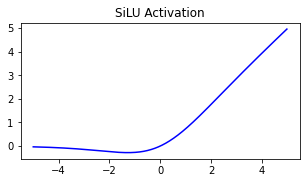

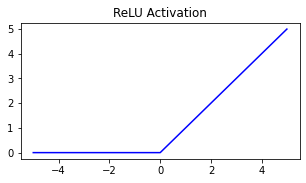

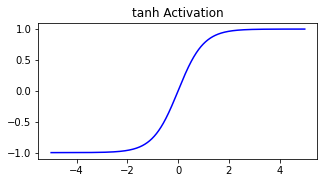

In [29]:
# SiLU vs ReLU

a = nn.SiLU()
b = nn.ReLU()
c = nn.Tanh()

x = torch.arange(-5, 5, .01)
# plt.ylim([-2, 6])

plt.figure(1)
plt.title("SiLU Activation")
plt.plot(x, a(x), color='b')


plt.figure(2)
plt.title("ReLU Activation")
plt.plot(x, b(x), color='b')


plt.figure(3)
plt.title("tanh Activation")
plt.plot(x, c(x), color='b')

plt.show()

In [121]:
class NN2(nn.Module):
    def __init__(self, d):
        super(NN2, self).__init__()
        self.stack = nn.Sequential(
            nn.Linear(2, d),
            nn.SiLU(), # nn.Tanh()
            nn.Linear(d, d),
            nn.SiLU(), # nn.Tanh()
            nn.Linear(d, d),
            nn.SiLU(), # nn.Tanh()
            nn.Linear(d, d),
            nn.SiLU(), # nn.Tanh()
            nn.Linear(d, 1)
        )

    def forward(self, x):
        return self.stack(x)
    
def dx(f, wrt, n):
    f = torch.sum(f)
    for i in range(n):
        grads = torch.autograd.grad(f, wrt, create_graph=True, allow_unused=True)[0]
        f = grads.sum()
    return grads

In [636]:
model = NN2(40)
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

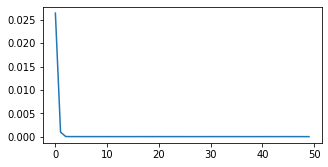

In [637]:
a = 0
b = 1
start_t = 0
end_t = 1
k = 1

f_exact_pt = lambda x: 6*torch.sin(torch.pi*x/b)
f_exact = lambda x: 6*np.sin(np.pi*x/b)
u_exact = lambda x, t: f_exact(x)*np.exp(-k*(np.pi/b)**2*t)

N = 15
x = np.linspace(a, b, N).reshape(-1, 1)
t = np.linspace(start_t, end_t, N).reshape(-1, 1)
X = np.array(np.meshgrid(x, t)).T.reshape(-1, 2)
x = torch.from_numpy(X[:, 0]).float().requires_grad_()
t = torch.from_numpy(X[:, 1]).float().requires_grad_()
X = torch.from_numpy(X).float()
X.requires_grad_()

batches = 50
epochs = 2000
error = []
y = u_exact(np.arange(0, 1, .01), 1) # exact y at t = 1
x_test = torch.arange(0, 1, .01)
t_test = torch.ones((x_test.shape))*1
test_points = torch.stack(((x_test, t_test)), axis=1)

coeffs = [1, 250, 60, 60] # 1 60 60 60 
for batch in range(batches):
    # Calculate Error at t = 1
    y_hat = model(test_points).detach().numpy()
    error.append(float(np.mean((y - y_hat)**2)))
    for e in range(0, epochs):
        optimizer.zero_grad()

        total_loss = 0
        
        # partial condition
        output = model(torch.stack((x, t), axis=1))
        dt = dx(output, t, 1)
        dxx = dx(output, x, 2)
        loss1 = torch.linalg.norm(dt - k*dxx, ord=2)
        
        # initial condition
        X1 = X[torch.where(X[:, 1] == start_t)]
        output = model(X1) # u(x, start_t)
        loss2 = torch.linalg.norm(output - f_exact_pt(X1[:, 0]), ord=2)
        
        # first boundary condition
        output = model(X[torch.where(X[:, 0] == a)]) # u(a, t)
        loss3 = torch.linalg.norm(output, ord=2)
        
        # second boundary condition
        output = model(X[torch.where(X[:, 0] == b)]) # u(b, t)
        loss4 = torch.linalg.norm(output, ord=2)
        
        total_loss = coeffs[0]*loss1 + coeffs[1]*loss2 + coeffs[2]*loss3 + coeffs[3]*loss4
        total_loss.backward()
        optimizer.step()
        
        # if e % (epochs/8) == 0:
            # print(f"Epoch: {e} Total Loss: {round(float(total_loss), 5)}, loss1: {round(float(loss1), 5)}, loss2: {round(float(loss2), 5)}, loss3: {round(float(loss3), 5)}, loss4: {round(float(loss4), 5)}")

plt.title("Error Convergence for u(x, 1)")
plt.ylabel("Error")
plt.xlabel("Batch")
plt.plot(error, color='b')
plt.show()

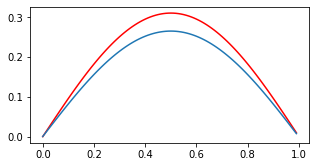

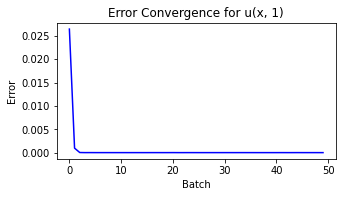

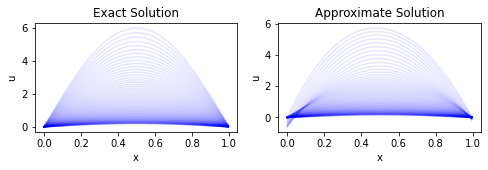

(70, 200)


In [675]:
dt = .005
x = np.arange(a, b, dt)
t = np.arange(start_t, .35, dt)
alph = 1/(1+np.exp(-t))
x_test = torch.arange(a, b, dt)

C = []
C_approx = []

figure, axis = plt.subplots(1, 2)
figure.set_size_inches(8, 2)
axis[0].set_title("Exact Solution")
axis[1].set_title("Approximate Solution")
axis[0].set_xlabel("x")
axis[0].set_ylabel("u")
axis[1].set_xlabel("x")
axis[1].set_ylabel("u")

for t, alph in zip(t, alph):
    t_test = torch.ones(x_test.shape) * t
    test_input = torch.stack((x_test, t_test), axis=1)
    u = u_exact(x, t)
    u_approx = model(test_input).detach().numpy().T[0]
    axis[0].plot(x, u, color='b', alpha=t/10+.1)
    axis[1].plot(x, u_approx, color='b', alpha=t/10+.1)
    C.append(u)
    C_approx.append(u_approx)
C = np.asarray(C)[::-1]
C_approx = np.asarray(C_approx)[::-1]
# plt.plot(6*np.sin(np.pi*x/b))
plt.show()
print(C.shape)

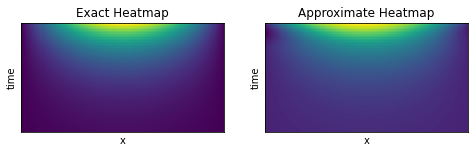

In [680]:
figure, axis = plt.subplots(1, 2)
figure.set_size_inches(8, 2)
axis[0].set_title("Exact Heatmap")
axis[1].set_title("Approximate Heatmap")
axis[0].set_ylabel("time")
axis[0].set_xlabel("x")
axis[1].set_ylabel("time")
axis[1].set_xlabel("x")
axis[0].pcolormesh(C)
axis[1].pcolormesh(C_approx)

axis[0].set_xticks([])
axis[0].set_yticks([])

axis[1].set_xticks([])
axis[1].set_yticks([])

plt.show()

In [ ]:
# import pygame

# pygame.init()
# window = pygame.display.set_mode([1200,600],pygame.RESIZABLE)
# clock = pygame.time.Clock()
# game_running = True 


# x = 0
# while game_running :
#     for event in pygame.event.get():
#         if event.type == pygame.QUIT:
#             print("closing the game")
#             game_running = False
#             break
#     window.fill((0, 0, 0))
#     pygame.draw.circle(window, (255, 255, 255), (800 + 50*model(torch.Tensor([x])).item(), 100), 10)
#     pygame.display.update()
#     x+=.001


# pygame.quit()